In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import scipy.ndimage

In [2]:
initialTrainX = "train-images.idx3-ubyte"
initialTrainY = "train-labels.idx1-ubyte"
testX = "t10k-images.idx3-ubyte"
testY = "t10k-labels.idx1-ubyte"

In [3]:
def convert(imgs,labels, outfile,n):
    imgf = open(imgs,"rb")
    labelf = open(labels,"rb")
    csvf = open(outfile,"w")

    imgf.read(16)
    labelf.read(8)
    images = []

    for i in range(n):
        image = [ord(labelf.read(1))]
        for j in range(28*28):
            image.append(ord(imgf.read(1)))
        images.append(image)

    for image in images:
        csvf.write(",".join(str(pix) for pix in image)+"\n")
    imgf.close()
    labelf.close()
    csvf.close()

In [4]:
'''convert(initial_train_X,initial_train_Y,"train.csv",60000)
convert(test_X,test_Y,"test.csv",10000)'''

'convert(initial_train_X,initial_train_Y,"train.csv",60000)\nconvert(test_X,test_Y,"test.csv",10000)'

In [5]:
xTrain = np.loadtxt('train.csv', delimiter = ',').T
yTrain =  xTrain[0, :]
yTrain = yTrain.reshape(1,60000)
xTrain = np.delete(xTrain, 0, axis=0)

In [6]:
xTest = np.loadtxt('test.csv', delimiter = ',').T
yTest =  xTest[0, :]
yTest = yTest.reshape(1,10000)
xTest = np.delete(xTest, 0, axis=0)

In [7]:
encoder = OneHotEncoder()
encoded = encoder.fit_transform(yTrain.reshape(-1, 1))
yTrain = encoded.toarray().T

In [8]:
print("shape of xTrain :", xTrain.shape)
print("shape of yTrain :", yTrain.shape)

shape of xTrain : (784, 60000)
shape of yTrain : (10, 60000)


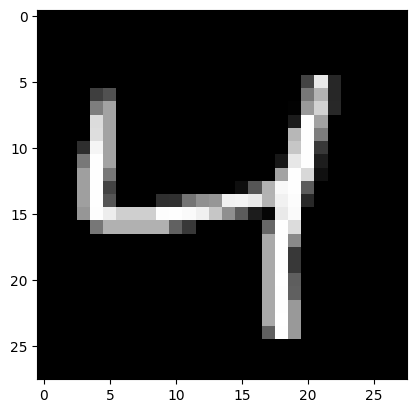

In [9]:
plt.imshow(xTrain[:, 2].reshape(28, 28), cmap = 'gray')
plt.show()

In [10]:
def rotate_image(image, angle):
    return scipy.ndimage.rotate(image, angle, reshape=False)

def translate_image(image, shift):
    return scipy.ndimage.shift(image, shift)

def add_noise(image, noise_level):
    noise = np.random.normal(scale=noise_level, size=image.shape)
    return np.clip(image + noise, 0, 255)

rotateX = np.empty((784,20000))
translatedX = np.empty((784,20000))
noiseAddedX = np.empty((784,20000))

for i in range(0,20000):
    angle = random.uniform(5,10)
    shift = random.uniform(1,3)

    rotateX[:,i] =  rotate_image(xTrain [:,i].reshape(28,28),angle).reshape(784)
    translatedX[:,i] =  translate_image(xTrain [:,i+20000].reshape(28,28),shift).reshape(784)
    noiseAddedX[:,i] =  add_noise(xTrain [:,i+40000].reshape(28,28),10).reshape(784)

yLabels = yTrain .copy()

xTrain  = np.concatenate((xTrain , rotateX), axis=1)
xTrain  = np.concatenate((xTrain , translatedX), axis=1)
xTrain  = np.concatenate((xTrain , noiseAddedX), axis=1)
yTrain  = np.concatenate((yTrain , yLabels),axis=1)

In [11]:
yTest = yTest.ravel()
yTest.shape
xTest = xTest.T

In [12]:
xTest,xDev,yTest,yDev=train_test_split(xTest,yTest,random_state=1234,test_size=0.5)
xTest = xTest.T
xDev = xDev.T
yTest = yTest.reshape(1,5000)
yDev= yDev.reshape(1,5000)

In [13]:
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)

In [14]:
def derivativeTanh(x):
    return (1 - np.power(np.tanh(x), 2))

def derivativeRelu(x):
    return np.array(x > 0, dtype = np.float32)

In [15]:
def initializeParameters(L0, L1, L2, L3):
    w1 = np.random.randn(L1, L0)*0.01
    b1 = np.zeros((L1, 1))
    
    w2 = np.random.randn(L2, L1)*0.01
    b2 = np.zeros((L2, 1))

    w3 = np.random.randn(L3, L2)*0.01
    b3 = np.zeros((L3, 1))
    
    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2,
        "w3" : w3,
        "b3" : b3,
    }
    
    return parameters

In [16]:
def forwardPropagation(x, parameters):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    w3 = parameters['w3']
    b3 = parameters['b3']
    
    z1 = np.dot(w1, x) + b1
    a1 = relu(z1)
    
    z2 = np.dot(w2, a1) + b2
    a2 = tanh(z2)

    z3 = np.dot(w3,a2) + b3
    a3 = softmax(z3)
    
    cache = {
        "z1" : z1,
        "a1" : a1,
        "z2" : z2,
        "a2" : a2,
        "z3" : z3,
        "a3" : a3
    }
    
    return cache

In [17]:
def costF(yPred, y):
    m = y.shape[1] 
    cost = -(1/m)*np.sum(y*np.log(yPred))
    
    return cost


# Backpropagation

$dZ_3 = ( A_3 - Y )$

$ dW_3 = \frac{1}{m}. dZ_3 . A_2^T$

$ dB_3 = \frac{1}{m}.sum(dZ_3, 1)$

$dZ_2 = W_3^T . dZ_3 * f_2^|(Z_2) $

$dW_2 = \frac{1}{m}.dZ_2 . A_1^T$

$dB_2 = \frac{1}{m}.sum(dZ_2, 1)$

$dZ_1 = W_2^T . dZ_2 * f_1^|(Z_1) $

$dW_1 = \frac{1}{m}.dZ_1.X^T$

$dB_1 = \frac{1}{m}.sum(dZ_1, 1)$

In [18]:
def backwardPropogation(x, y, parameters, cache):
    
    w3 = parameters['w3']
    w2 = parameters['w2']
    
    a1 = cache['a1']
    a2 = cache['a2']
    a3 = cache['a3']
    
    m = x.shape[1]
    
    dz3 = (a3 - y)
    dw3 = (1/m)*np.dot(dz3, a2.T)
    db3 = (1/m)*np.sum(dz3, axis = 1, keepdims = True)
    
    dz2 = (1/m)*np.dot(w3.T, dz3)*derivativeTanh(a2)
    dw2 = (1/m)*np.dot(dz2, a1.T)
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)

    dz1 = (1/m)*np.dot(w2.T, dz2)*derivativeRelu(a1)
    dw1 = (1/m)*np.dot(dz1, x.T)
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)
    
    gradients = {
        "dw1" : dw1,
        "db1" : db1,
        "dw2" : dw2,
        "db2" : db2,
        "dw3" : dw3,
        "db3" : db3
    }
    
    return gradients

In [19]:
def updateParameters(parameters, gradients, learningRate):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    w3 = parameters['w3']
    b3 = parameters['b3']
    
    dw1 = gradients['dw1']
    db1 = gradients['db1']
    dw2 = gradients['dw2']
    db2 = gradients['db2']
    dw3 = gradients['dw3']
    db3 = gradients['db3']
    
    w1 = w1 - learningRate*dw1
    b1 = b1 - learningRate*db1
    w2 = w2 - learningRate*dw2
    b2 = b2 - learningRate*db2
    w3 = w3 - learningRate*dw3
    b3 = b3 - learningRate*db3

    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2,
        "w3" : w3,
        "b3" : b3
    }
    
    return parameters

In [20]:
def accuracy(inp, labels, parameters):
    output = forwardPropagation(inp, parameters)
    yPred = output['a3']
    yPred = np.argmax(yPred, 0)
    labels = np.argmax(labels, 0)
    acc = np.mean(yPred == labels)*100
    
    return acc

In [21]:
def model(x, y, L1, L2, learningRate, epochs):
    
    L0 = x.shape[0]
    L3 = y.shape[0]
    
    cost_list = []
    
    parameters = initializeParameters(L0, L1, L2 , L3)
    
    for i in range(epochs):
        
        cache = forwardPropagation(x, parameters)
        
        cost = costF(cache['a3'], y)
        
        gradients = backwardPropogation(x, y, parameters, cache)
        
        parameters = updateParameters(parameters, gradients, learningRate)
        
        cost_list.append(cost)
        
        print("Cost after", i, "iterations is :", cost)
        
    return parameters, cost_list


In [22]:
epochs = 150
L1 = 1000
L2 = 1000
learningRate = 0.1
parameters, Cost = model(xTrain, yTrain, L1, L2, learningRate, epochs)

Cost after 0 iterations is : 2.365667028698666
Cost after 1 iterations is : 2.070715579419223
Cost after 2 iterations is : 2.0446749981477605
Cost after 3 iterations is : 2.221708465495003
Cost after 4 iterations is : 1.972852419292033
Cost after 5 iterations is : 1.8830983800256125
Cost after 6 iterations is : 1.4396559921158485
Cost after 7 iterations is : 1.7832586872567464
Cost after 8 iterations is : 1.3597146491670031
Cost after 9 iterations is : 1.6951734440704282
Cost after 10 iterations is : 1.5423581311380998
Cost after 11 iterations is : 1.445931813494664
Cost after 12 iterations is : 1.233012620608577
Cost after 13 iterations is : 0.9719097833469632
Cost after 14 iterations is : 1.0516138382294982
Cost after 15 iterations is : 0.9834110556132657
Cost after 16 iterations is : 1.0196215557016244
Cost after 17 iterations is : 0.9736774754140872
Cost after 18 iterations is : 0.9970650657743342
Cost after 19 iterations is : 1.1104787881884381
Cost after 20 iterations is : 0.8942

In [23]:
output = forwardPropagation(xDev, parameters)
yDevPred = encoder.inverse_transform(output['a3'].T).T
output = forwardPropagation(xTest, parameters)
yTestPred = encoder.inverse_transform(output['a3'].T).T

In [24]:
yDevAcc = accuracy_score(yDev.T, yDevPred.T)
yTestAcc = accuracy_score(yTest.T, yTestPred.T)
yDevPrecision = precision_score(yDev.T, yDevPred.T,average='weighted')
yTestPrecision = precision_score(yTest.T, yTestPred.T,average='weighted')
yDevRecall = recall_score(yDev.T, yDevPred.T,average='weighted')
yTestRecall = recall_score(yTest.T, yTestPred.T,average='weighted')
yDevf1 = f1_score(yDev.T, yDevPred.T,average='weighted')
yTestf1 = f1_score(yTest.T, yTestPred.T,average='weighted')

In [25]:
print("Dev Accuracy:", yDevAcc)
print("Dev Precision:", yDevPrecision)
print("Dev Recall:", yDevRecall)
print("Dev F1 Score:", yDevf1)

Dev Accuracy: 0.911
Dev Precision: 0.9109351027205442
Dev Recall: 0.911
Dev F1 Score: 0.910848761232162


In [26]:
print("Test Accuracy:", yTestAcc)
print("Test Precision:", yTestPrecision)
print("Test Recall:", yTestRecall)
print("Test F1 Score:", yTestf1)

Test Accuracy: 0.9118
Test Precision: 0.9119067557825219
Test Recall: 0.9118
Test F1 Score: 0.911709909594875


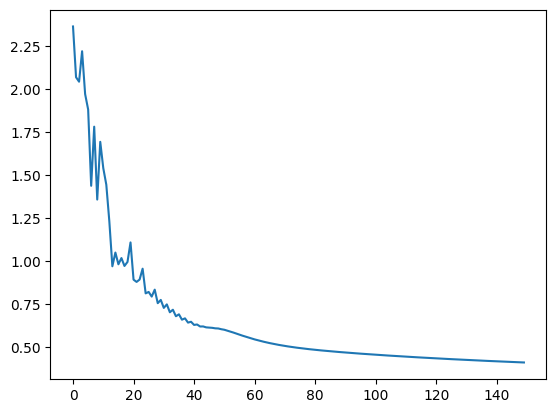

In [28]:
plt.plot(Cost)